## Customers Segmentation Using Credit Card Behaviors

#### Purpose
- to develop a customer segmentation to define marketing strategy.

#### Dataset
- usage behavior of \~9000 active credit card holders during 6 months.
- customers have 18 behavioral variables.
- data source: https://www.kaggle.com/datasets/arjunbhasin2013/ccdata/data
  - alternative source: https://github.com/andreduong-zz/credit-card-clustering/raw/refs/heads/master/CC%20GENERAL.csv
- variable details:

| Variable Name | Detail |
|:---|:---|
|CUST_ID | Identification of Credit Card holder (Categorical) |
| BALANCE | Balance amount left in their account to make purchases |
| BALANCE_FREQUENCY | How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated) |
| PURCHASES | Amount of purchases made from account |
| ONEOFF_PURCHASES | Maximum purchase amount done in one-go |
| INSTALLMENTS_PURCHASES | Amount of purchase done in installment |
| CASH_ADVANCE | Cash in advance given by the user |
| PURCHASES_FREQUENCY | How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased) |
| ONEOFF_PURCHASES_FREQUENCY | How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased) |
| PURCHASES_INSTALLMENTS_FREQUENCY | How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done) |
| CASH_ADVANCE_FREQUENCY | How frequently the cash in advance being paid |
| CASH_ADVANCE_TRX | Number of Transactions made with "Cash in Advanced" |
| PURCHASES_TRX | Numbe of purchase transactions made |
| CREDIT_LIMIT | Limit of Credit Card for user |
| PAYMENTS | Amount of Payment done by user |
| MINIMUM_PAYMENTS | Minimum amount of payments made by user |
| PRC_FULL_PAYMENT | Percent of full payment paid by user |
| TENURE | Tenure of credit card service for user|

#### Conclusion
- Method in brief:
  - observed *natural clusters* in variable correlations
  - selected related key variables for clustering: `BALANCE`, `PAYMENTS`, and `MINIMUM_PAYMENTS`
  - clustering model: *Bayesian Gaussian Mixture model*
  - clustering reliability test: *98+%* (for the case of five clusters)
- Resulting customer groups:
  - *conservative users* (small credit usuage)
  - *moderate users* (high-value users)
  - *immoderate users* (revolver)
  - *new users*
- Suggestions for marketing strategy
  - encourage *conservative users* to spend more and to use minimum payment and cash advance services
  - use loyality programs to retain *moderate users*, and encourage them to invite new users
  - encourage *new users* to use service often (to collect more usuage records)

#### MIT License
Copyright 2024 ddotplus@github

## Work Procedures
- Load Python Libraries
- Load Data And Data Cleaning
- EDA (Explortary Data Analysis)
- Customer Segmentation
- Meaning of Customer Groups
- Suggestions on Marketing Strategy

### Load Python Libraries
requirements: 
```
numpy==1.24.4
pandas==2.0.3
matplotlib==3.7.5
seaborn==0.13.2
scikit-learn==1.3.2
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import BayesianGaussianMixture

import warnings
warnings.filterwarnings('ignore')

## Color list of tab10 colormap
tab10 = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple',
         'tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']

### Load Data And Data Cleaning
- download data automatically from internet if not found locally
- data cleaning: fill NULL values
- data frames:
  - `df`: data after cleaning
  - `dfp`: add a Power Scale on monetory numbers for better visualization

In [2]:
## Load raw data to pandas Dataframe
data_url = 'https://raw.githubusercontent.com/andreduong-zz/credit-card-clustering/refs/heads/master/CC%20GENERAL.csv'
data_filename = 'CC GENERAL.csv'
try:
    df_raw = pd.read_csv(data_filename)
except FileNotFoundError:
    df_raw = pd.read_csv(data_url)
    df_raw.to_csv(data_filename, index=False)

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [4]:
## Understand NULL values
n0 = df_raw[df_raw['CREDIT_LIMIT'].isnull()].shape[0]
print(f"CREDIT_LIMIT: minimum value is {df_raw['CREDIT_LIMIT'].min()}, and found {n0} NULL value(s).")
dt = df_raw[df_raw['MINIMUM_PAYMENTS'].isnull()]
n1 = dt.shape[0]
n1a = round(dt[dt['PAYMENTS']==0].shape[0]/n1*100,1)
print(f"MINIMUM_PAYMENTS: minimum value is {df_raw['MINIMUM_PAYMENTS'].min()}, and found {n1} NULL value(s).")
print(f"MINIMUM_PAYMENTS: for customers with NULL value, found {n1a}% with PAYMENTS = 0.")

CREDIT_LIMIT: minimum value is 50.0, and found 1 NULL value(s).
MINIMUM_PAYMENTS: minimum value is 0.019163, and found 313 NULL value(s).
MINIMUM_PAYMENTS: for customers with NULL value, found 76.7% with PAYMENTS = 0.


In [5]:
## Clean data: 
##   - replace NULL values with 0 in `CREDIT_LIMIT` and `MINIMUM_PAYMENTS`
df = df_raw.copy()
df['CREDIT_LIMIT'].fillna(0, inplace=True)
df['MINIMUM_PAYMENTS'].fillna(0, inplace=True)

In [6]:
df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4493.947277,1733.143852,833.983453,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.922543,2895.063757,2335.989918,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,163.028164,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,289.628402,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,788.713501,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


In [7]:
## convert money-related numbers to power scale 
## (similar to log scale, for better visulization)
dfp = df.copy()
cols = ['BALANCE','PURCHASES','ONEOFF_PURCHASES','INSTALLMENTS_PURCHASES',
        'CASH_ADVANCE','CREDIT_LIMIT','PAYMENTS','MINIMUM_PAYMENTS']

def add_ps (str_list):
    ps = '_PowerScaled'
    if isinstance(str_list,str):
        return str_list + ps
    elif isinstance(str_list,list):
        return [s+ps for s in str_list]
    elif isinstance(str_list,tuple):
        return tuple([s+ps for s in str_list])
    else:
        raise ValueError('func add_ps(): input error')

for c in cols:
    dfp[c] = np.power(dfp[c], 0.2)
    dfp.rename(columns={c: add_ps(c)},inplace=True)

In [8]:
dfp.describe()

,BALANCE_PowerScaled,BALANCE_FREQUENCY,PURCHASES_PowerScaled,ONEOFF_PURCHASES_PowerScaled,INSTALLMENTS_PURCHASES_PowerScaled,CASH_ADVANCE_PowerScaled,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT_PowerScaled,PAYMENTS_PowerScaled,MINIMUM_PAYMENTS_PowerScaled,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000
mean,3.669375,0.877271,2.844501,1.851708,1.901168,1.978878,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,5.114726,3.900046,3.244534,0.153715,11.517318
std,1.305661,0.236904,1.771298,1.917700,1.776689,2.177420,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,0.835051,1.136780,1.040917,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
25%,2.640177,0.888889,2.087448,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,4.373448,3.286263,2.769826,0.000000,12.000000
50%,3.874727,1.000000,3.247647,2.069935,2.454019,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,4.959344,3.859990,3.107193,0.000000,12.000000
75%,4.597545,1.000000,4.065133,3.566942,3.421113,4.067833,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,5.788722,4.526917,3.796504,0.142857,12.000000
max,7.177079,1.000000,8.671802,8.356983,7.420557,8.603453,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,7.860031,8.730485,9.476015,1.000000,12.000000


### EDA (Explortary Data Analysis)

- Categories of original variables (raw-data column names, in upper cases):
  - customer status: `BALANCE`, `CREDIT_LIMIT`, `PRC_FULL_PAYMENT`, `TENURE`
  - borrowed by customer: `PURCHASES` (`ONEOFF_PURCHASES`, `INSTALLMENTS_PURCHASES`), `CASH_ADVANCE`
  - paid by customer: `PAYMENTS`, `MINIMUM_PAYMENTS`
  - statistics:
    - `BALANCE_FREQUENCY`
    - `PURCHASES_FREQUENCY`, `ONEOFF_PURCHASES_FREQUENCY`, `PURCHASES_INSTALLMENTS_FREQUENCY`
    - `CASH_ADVANCE_FREQUENCY`
    - `PURCHASES_TRX`, `CASH_ADVANCE_TRX`
- Newly added variables (new column names, in title cases):
  - `Purchases_Label`: purchases types (OneOff, Installments), see **EDA-2**
  - `Borrow_Label`: borrow types (Purchases, Cash_Advance), see **EDA-3**
  - `PAYMENTS_Proportion`: `PAYMENTS` / ( `PAYMENTS` + `MINIMUM_PAYMENTS`), see **EDA-4**
  - `BALACE_CREDIT_Ratio` = `BALANCE` / `CREDIT_LIMIT`, see **EDA-5**
- Found linear relations:
  - roughly speaking, `PURCHASES` correlates linearly with `PAYMENTS`
  - purchases equation: `PURCHASES` = `ONEOFF_PURCHASES` + `INSTALLMENTS_PURCHASES`
- **Found natural clusters** in correlations among `BALANCE`,`PURCHASES`, `PAYMENTS`, `MINIMUM_PAYMENTS`
  - only 2D correlations presented here, for initial study
  - this forms the base for customer clustering in next part

#### EDA-1: Strong Correlations among `BALANCE`, `PURCHASES`, `PAYMENTS`
- Natural clusters visible in `BALANCE`-`PAYMENTS` correlation
- `PURCHASES` correlates linearly with `PAYMENTS`, but less capable of distinguishing clusters.
    - possible reason:
`PURCHASES` is customer-borrowing in the six-month peroid;
`PAYMENTS` is customer-paying for the borrowed, including those before the peroid;
in other words, `PAYMENTS` may be statistical results of data history, much longer
than the six-month; therefore contains more information.

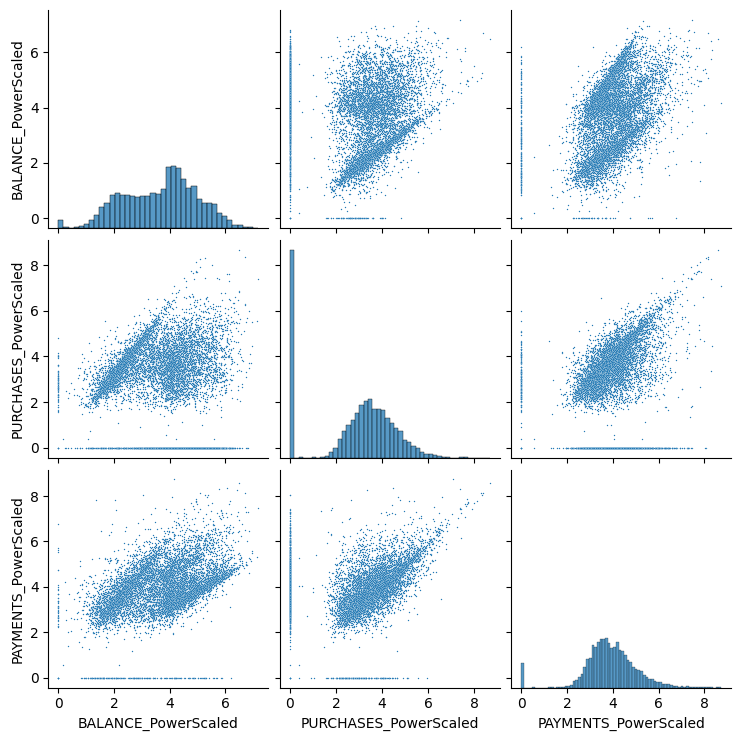

In [9]:
## pair correlations
sns.pairplot(dfp[add_ps(['BALANCE','PURCHASES','PAYMENTS'])],plot_kws=dict(s=1));

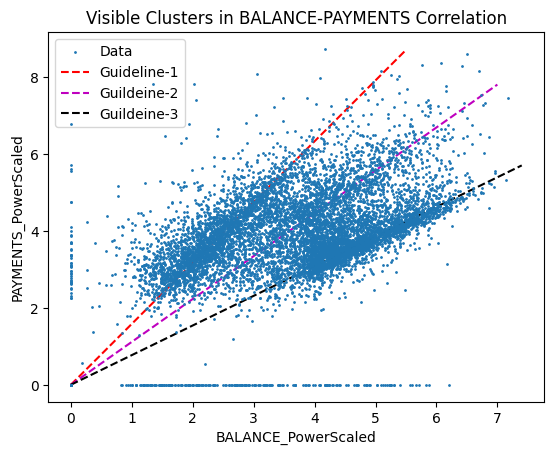

In [10]:
## visible clusters in `BALANCE`-`PAYMENTS` plot
fig, ax = plt.subplots()
colx = add_ps('BALANCE')
coly = add_ps('PAYMENTS')
ax.scatter(dfp[colx],dfp[coly],zorder=10,s=1)
ax.plot([0,5.5],[0,8.7],'r--')
ax.plot([0,7],[0,7.8],'m--')
ax.plot([0,7.4],[0,5.7],'k--')
ax.set_xlabel(colx)
ax.set_ylabel(coly)
ax.legend(['Data','Guideline-1','Guildeine-2','Guildeine-3'])
ax.set_title('Visible Clusters in BALANCE-PAYMENTS Correlation');

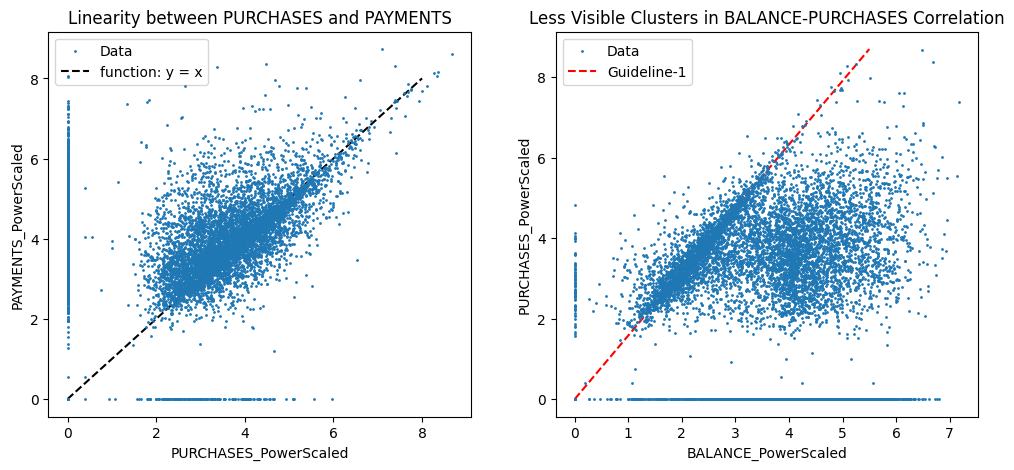

In [11]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

colx = add_ps('PURCHASES')
coly = add_ps('PAYMENTS')
ax[0].scatter(dfp[colx],dfp[coly],zorder=10,s=1)
ax[0].plot([0,8],[0,8],'k--')
ax[0].set_xlabel(colx)
ax[0].set_ylabel(coly)
ax[0].legend(['Data','function: y = x'])
ax[0].set_title('Linearity between PURCHASES and PAYMENTS')

colx = add_ps('BALANCE')
coly = add_ps('PURCHASES')
ax[1].scatter(dfp[colx],dfp[coly],zorder=10,s=1)
ax[1].plot([0,5.5],[0,8.7],'r--')
ax[1].set_xlabel(colx)
ax[1].set_ylabel(coly)
ax[1].legend(['Data','Guideline-1'])
ax[1].set_title('Less Visible Clusters in BALANCE-PURCHASES Correlation');

#### EDA-2: `PURCHASES` (`ONEOFF_PURCHASES`, `INSTALLMENTS_PURCHASES`) and Their Frequency
- Purchases have two components:
  - `PURCHASES` = `ONEOFF_PURCHASES` + `INSTALLMENTS_PURCHASES`
  - the relation is broken only by 0.2% purchases records (with mismatch error larger than 0.01, in monetory unit)
  - but no similar linear relation among their frequencies:
    - `PURCHASES_FREQUENCY` <>  a * `ONEOFF_PURCHASES_FREQUENCY` + b * `PURCHASES_INSTALLMENTS_FREQUENCY` + c
    - probably because `ONEOFF_PURCHASES_FREQUENCY` and `PURCHASES_INSTALLMENTS_FREQUENCY` counting are signficantly coupled
- Simplified customer types on purchases ( added to `dfp['Purchases_Label']`):
  - 23% with zero `PURCHASES` or inconsistent purchase records (0.2%)
  - 21% with only `ONEOFF_PURCHASES`
  - 25% with only `INSTALLMENTS_PURCHASES`
  - 31% with mixture of `ONEOFF_PURCHASES` and `INSTALLMENTS_PURCHASES`
- The above purchase types have no obvious correlation to clusters in `BALANCE`-`PAYMENTS` plot

In [12]:
## Purchases relation
n0 = df.shape[0]
n1 = df[abs(df['PURCHASES']-df['ONEOFF_PURCHASES']-df['INSTALLMENTS_PURCHASES'])<0.01].shape[0]
n1p = round(n1/n0*100,1)
print('Only Two Types of Purchases: PURCHASES = ONEOFF_PURCHASES + INSTALLMENTS_PURCHASES')
print(f'There are {n1} ({n1p}%) customers with consistent purchase records (match the above within error of 0.01).')

Only Two Types of Purchases: PURCHASES = ONEOFF_PURCHASES + INSTALLMENTS_PURCHASES
There are 8931 (99.8%) customers with consistent purchase records (match the above within error of 0.01).


Customer types on purchases:
   23.0% with zero PURCHASES or inconsistent purchase records
   20.9% with only ONEOFF_PURCHASES
   25.1% with only INSTALLMENTS_PURCHASES
   31.0% with mixture of ONEOFF_PURCHASES and INSTALLMENTS_PURCHASES


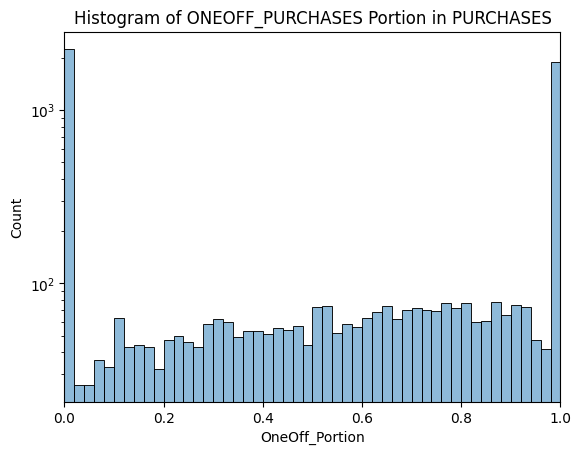

In [13]:
## Portions of different customer types of purchases
df_poi = df[['PURCHASES','ONEOFF_PURCHASES','INSTALLMENTS_PURCHASES']]
df_poi = df_poi[(df_poi['PURCHASES']>0)&(abs(df_poi['PURCHASES']-df_poi['ONEOFF_PURCHASES']
                                             -df_poi['INSTALLMENTS_PURCHASES'])<0.01)]
df_poi['OneOff_Portion'] = df_poi['ONEOFF_PURCHASES']/(df_poi['INSTALLMENTS_PURCHASES']+
                                 df_poi['ONEOFF_PURCHASES']).map(lambda x: 1 if x==0 else x)
g = sns.histplot(df_poi['OneOff_Portion'],bins=50,alpha=0.5)
g.set_xlim([0,1])
g.set_yscale('log')
g.set_title('Histogram of ONEOFF_PURCHASES Portion in PURCHASES')

n0 = round((1-df_poi.shape[0]/df.shape[0])*100,1)
n1 = round(df_poi[df_poi['OneOff_Portion']==1].shape[0]/df.shape[0]*100,1)
n2 = round(df_poi[df_poi['OneOff_Portion']==0].shape[0]/df.shape[0]*100,1)
n3 = round(100-n0-n1-n2,1)
print('Customer types on purchases:')
print(f'   {n0}% with zero PURCHASES or inconsistent purchase records')
print(f'   {n1}% with only ONEOFF_PURCHASES')
print(f'   {n2}% with only INSTALLMENTS_PURCHASES')
print(f'   {n3}% with mixture of ONEOFF_PURCHASES and INSTALLMENTS_PURCHASES')

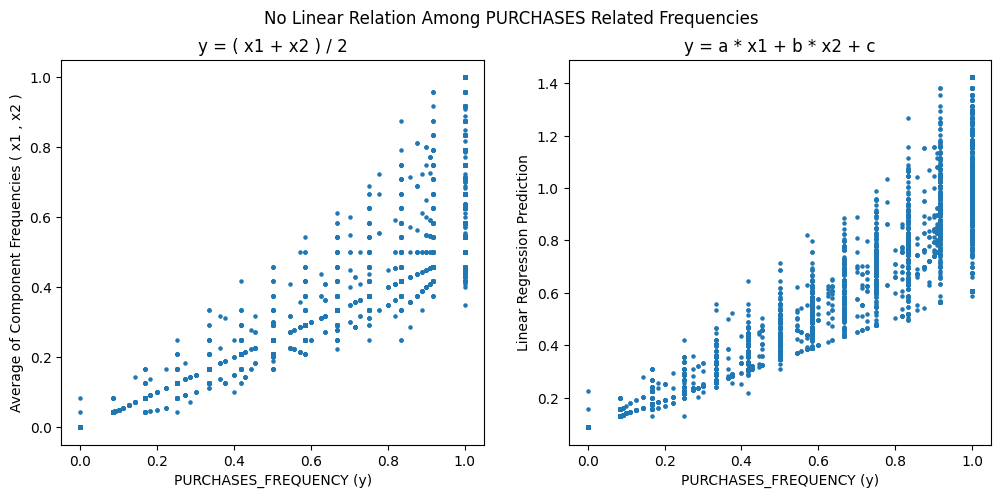

In [14]:
## Linear Regression fit for test linear relation between the frequencies
from sklearn.linear_model import LinearRegression
rg = LinearRegression().fit(df[['ONEOFF_PURCHASES_FREQUENCY','PURCHASES_INSTALLMENTS_FREQUENCY']],df['PURCHASES_FREQUENCY'])
rg_predict = rg.predict(df[['ONEOFF_PURCHASES_FREQUENCY','PURCHASES_INSTALLMENTS_FREQUENCY']])

fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].scatter(df['PURCHASES_FREQUENCY'],(df['ONEOFF_PURCHASES_FREQUENCY']+df['PURCHASES_INSTALLMENTS_FREQUENCY'])/2,s=5)
ax[0].set_xlabel('PURCHASES_FREQUENCY (y)')
ax[0].set_ylabel('Average of Component Frequencies ( x1 , x2 )')
ax[0].set_title('y = ( x1 + x2 ) / 2')
ax[1].scatter(df['PURCHASES_FREQUENCY'],rg_predict,s=5)
ax[1].set_xlabel('PURCHASES_FREQUENCY (y)')
ax[1].set_ylabel('Linear Regression Prediction')
ax[1].set_title('y = a * x1 + b * x2 + c')
fig.suptitle('No Linear Relation Among PURCHASES Related Frequencies');

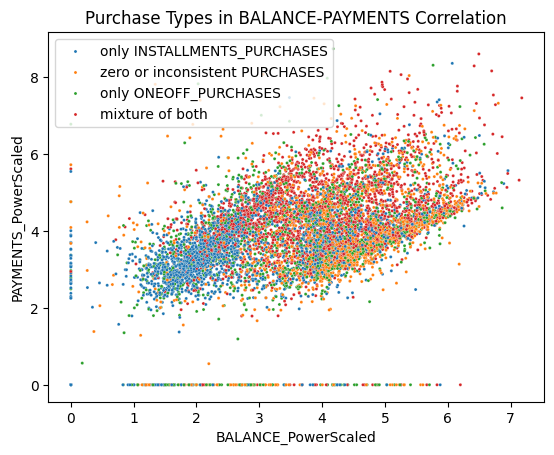

In [15]:
## Add "Purchases_Label" column to data frame "dfp"
## Purchase types play no significant role in BALANCE-PAYMENTS correlation
purchases_label = ['zero or inconsistent PURCHASES', 'only ONEOFF_PURCHASES',
                   'only INSTALLMENTS_PURCHASES','mixture of both']
dfp['Purchases_Label'] = purchases_label[0]
dfp.loc[df_poi.index,'Purchases_Label'] =  df_poi['OneOff_Portion'].map(
    lambda x: purchases_label[1] if x==1 else (
              purchases_label[2] if x==0 else
              purchases_label[3]))
fig, ax = plt.subplots()
sns.scatterplot(data=dfp,x=add_ps('BALANCE'),y=add_ps('PAYMENTS'),hue='Purchases_Label',palette='tab10',s=5,ax=ax)
ax.legend().set_title('')
ax.set_title('Purchase Types in BALANCE-PAYMENTS Correlation');

#### EDA-3: The Customer Borrowed (`PURCHASES`, `CASH_ADVANCE`) and Related Statistics
- Customer spending in two ways: `PURCHASES` and `CASH_ADVANCE`
- Define new variable `Borrow_Label` (added to `dfp['Borrow_Label']`)
  - "no borrow" (0.0%)
  - "only PURCHASES" (51.7%)
  - "only CASH_ADVANCE" (22.8%)
  - "mixture of both" (25.5%)
- No significant features found related to `PURCHASES_FREQUENCY`,`CASH_ADVANCE_FREQUENCY`,`PURCHASES_TRX`,`CASH_ADVANCE_TRX`

In [16]:
borrow_label = ['no borrow','only PURCHASES','only CASH_ADVANCE','mixture of both']
dt = df[['PURCHASES','CASH_ADVANCE']]
dt['Borrow_Label_Sort'] = dt['PURCHASES'].map(lambda x: 0 if x==0 else 1) + dt['CASH_ADVANCE'].map(lambda x: 0 if x==0 else 2)
dt['Borrow_Label'] = dt['Borrow_Label_Sort'].map({i:borrow_label[i] for i in range(4)})
dfp['Borrow_Label'] = dt['Borrow_Label']

In [17]:
n = [round(df[dfp['Borrow_Label']==borrow_label[0]].shape[0]/df.shape[0]*100,1),
     round(df[dfp['Borrow_Label']==borrow_label[1]].shape[0]/df.shape[0]*100,1),
     round(df[dfp['Borrow_Label']==borrow_label[2]].shape[0]/df.shape[0]*100,1),
     round(df[dfp['Borrow_Label']==borrow_label[3]].shape[0]/df.shape[0]*100,1)]
print('Define Borrow_Label (proportion):')
for i in range(len(borrow_label)):
    print(f'  - "{borrow_label[i]}" ({n[i]}%)')

Define Borrow_Label (proportion):
  - "no borrow" (0.0%)
  - "only PURCHASES" (51.7%)
  - "only CASH_ADVANCE" (22.8%)
  - "mixture of both" (25.5%)


In [18]:
## plot all pair correlation among Borrow-related variables
#sns.pairplot(dfp[add_ps(['PURCHASES','CASH_ADVANCE'])+['PURCHASES_FREQUENCY','CASH_ADVANCE_FREQUENCY','PURCHASES_TRX','CASH_ADVANCE_TRX']],plot_kws=dict(s=1))

#### EDA-4: Customer Payments
- Strong correlations between `MINIMUM_PAYMENTS` and `PAYMENTS`
- For customers with positive `MINIMUM_PAYMENTS` (96.5%):
  - linearity dominated at two peaks of slope angles: 45 degrees and nearly 90 degrees
  - rotated along a reference point, close to (110,110)
  - corresponding to two ideal cases:
    - `PAYMENTS` equals `MINIMUM_PAYMENTS`
    - `PAYMENTS` is almost independent of `MINIMUM_PAYMENTS`
- Define a robust indicator ( added to `dfp['PAYMENTS_Proportion']`):
  - `PAYMENTS_Proportion` = `PAYMENTS` / ( `PAYMENTS` + `MINIMUM_PAYMENTS`)
  - its value distribution peaks at:
    - 0 ( zero `PAYMENTS`)
    - 0.5 (`PAYMENTS` equals to `MINIMUM_PAYMENTS`)
    - 0.9 (`PAYMENTS` is 9 times as many as `MINIMUM_PAYMENTS`)
  - it may help to idenfity clusters in `BALANCE`-`PAYMENTS` correlation
    - this means that `MINIMUM_PAYMENTS` may play a role in the clusters 

Found 8637 (96.5%) customers has positive `MINIMUM_PAYMENTS`.


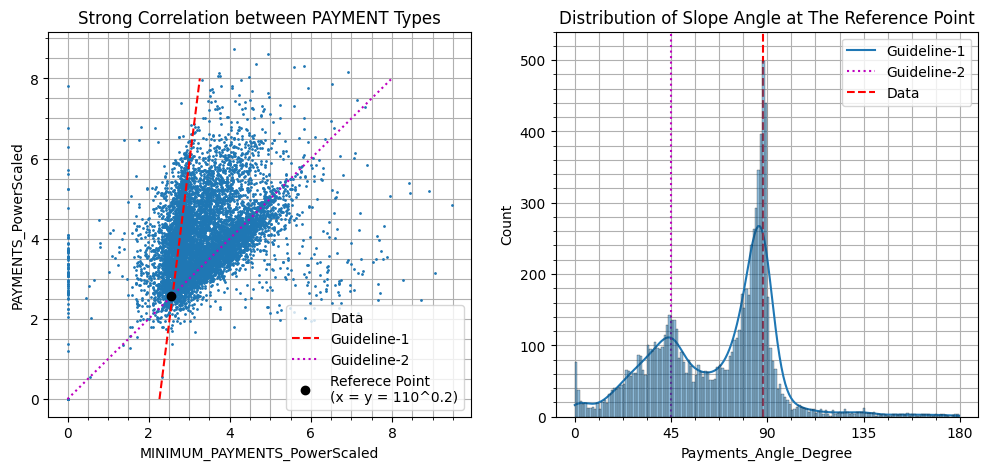

In [19]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

## Correlation between two payment-related variables
## found interesting linear features
colx = add_ps('MINIMUM_PAYMENTS')
coly = add_ps('PAYMENTS')
ax[0].scatter(dfp[colx],dfp[coly],zorder=2,s=1)
ax[0].plot([60**0.2,370**0.2],[0,8],'r--')
ax[0].plot([0,8],[0,8],'m:')
ax[0].plot([110**0.2],[110**0.2],'ko')
ax[0].minorticks_on()
ax[0].grid()
ax[0].grid(which='minor')
ax[0].set_xlabel(colx)
ax[0].set_ylabel(coly)
ax[0].legend(['Data','Guideline-1','Guideline-2',
              'Referece Point\n(x = y = 110^0.2)'],loc='lower right')
ax[0].set_title('Strong Correlation between PAYMENT Types')

## Further details of the linear features, described by slope (angles)
## Found: peaks of slope angle at 45 deg. and nearly 90 deg.
##        (artifical peak at 0 deg. as indicated by discontinuity of the counts
##         at 0 deg. and 180 deg.; may result from convention of arctan2() singlarity 
##         defined at the reference point)
dt = df[['MINIMUM_PAYMENTS','PAYMENTS']]
dt[add_ps('MINIMUM_PAYMENTS')] = dfp[add_ps('MINIMUM_PAYMENTS')]
dt[add_ps('PAYMENTS')] = dfp[add_ps('PAYMENTS')]
dt[add_ps('BALANCE')] = dfp[add_ps('BALANCE')]
dt = dt[dt['MINIMUM_PAYMENTS']>0]
print(f'Found {dt.shape[0]} ({round(dt.shape[0]/df.shape[0]*100,1)}%) customers has positive `MINIMUM_PAYMENTS`.')
xy0 = 110
dt['Payments_Angle_Degree'] = abs(np.arctan2(dt['PAYMENTS']-xy0,
                                             dt['MINIMUM_PAYMENTS']-xy0))/np.pi*180

sns.histplot(dt['Payments_Angle_Degree'],bins=160,kde=True,ax=ax[1],zorder=10)
ax[1].plot([45,45],[0,540],'m:')
ax[1].plot([88,88],[0,540],'r--')
ax[1].set_xticks(np.arange(0,181,45))
ax[1].set_ylim([0,540])
ax[1].minorticks_on()
ax[1].grid()
ax[1].grid(which='minor')
ax[1].legend(['Guideline-1','Guideline-2','Data'])
ax[1].set_title('Distribution of Slope Angle at The Reference Point');

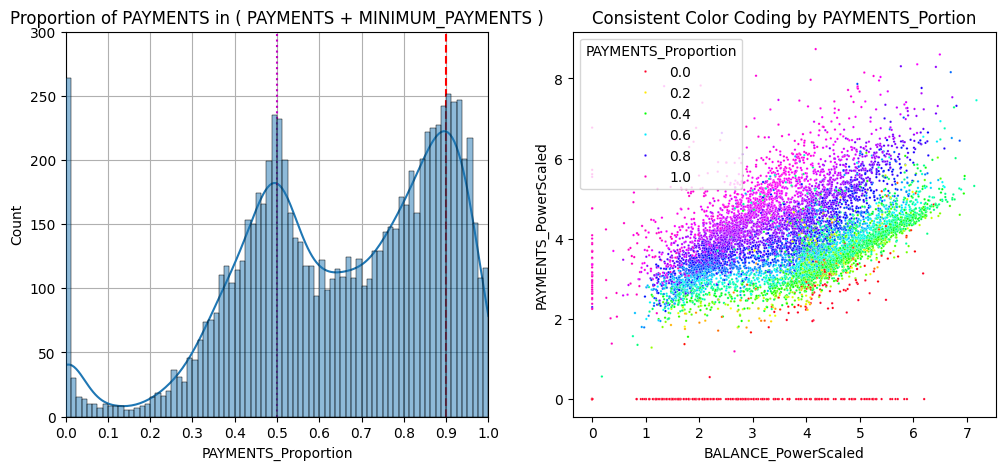

In [20]:
## Define a more robust indicator: PAYMENTS_Proportion = PAYMENTS / ( PAYMENTS + MINIMUM_PAYMENTS)
##    (zero has a clear meaning, i.e. zero PAYMENTS)
## Found it is consistently distributed along clusters in `BALANCE`-`PAYMENTS` correlation plot
dfp['PAYMENTS_Proportion'] = df['PAYMENTS']/(df['PAYMENTS']+df['MINIMUM_PAYMENTS']).map(lambda x: 1 if x==0 else x)

fig, ax = plt.subplots(1,2,figsize=(12,5))
sns.histplot(dfp['PAYMENTS_Proportion'],bins=80,kde=True,zorder=10,ax=ax[0])
ax[0].plot([0.5,0.5],[0,300],'m:')
ax[0].plot([0.9,0.9],[0,300],'r--')
ax[0].set_xticks(np.arange(0,1.1,0.1))
ax[0].set_xlim([0,1])
ax[0].set_ylim([0,300])
ax[0].grid()
ax[0].set_title('Proportion of PAYMENTS in ( PAYMENTS + MINIMUM_PAYMENTS )')

sns.scatterplot(data=dfp,x=add_ps('BALANCE'),y=add_ps('PAYMENTS'),hue='PAYMENTS_Proportion',palette='gist_rainbow',s=3,ax=ax[1])
ax[1].set_title('Consistent Color Coding by PAYMENTS_Portion');

In [21]:
## a quick comparison between PAYMENTS_Portion and Payments_Angle_Degree
#dt['PAYMENTS_Proportion'] = dt['PAYMENTS']/(dt['PAYMENTS']+dt['MINIMUM_PAYMENTS']).map(lambda x: 1 if x==0 else x)
#sns.scatterplot(data=dt,x='Payments_Angle_Degree',y='PAYMENTS_Portion',s=1)

#### EDA-5: More about Customer Status
- Define a status indicator: ( added to `dfp['BALACE_CREDIT_Ratio']`)
  - `BALACE_CREDIT_Ratio` = `BALANCE` / `CREDIT_LIMIT`  
  - 2.5% customers with `BALANCE` > `CREDIT_LIMIT`
  - 0.3% customers with `BALANCE` > 1.2 * `CREDIT_LIMIT`
  - so, set upper boundary to 1.2 ( for convenience of plotting )
- 66% customers with `PRC_FULL_PAYMENT` = 0. Therefore, `PRC_FULL_PAYMENT` is uninformative for a good clustering.
- 69% customers with a max. BALANCE_FREQUENCY = 1. Therefore, `BALANCE_FREQUENCY` is uninformative as well.
- 85% customers with `TENURE` = 12 (months). Therefore, `TENURE` is uninformative, too.
- Discretized values in `CREDIT_LIMIT` and `BALANCE_FREQUENCY` essentially reduce clustering visibility.

In [22]:
## Define ratio variable between `BALANCE` and `CREDIT_LIMIT`
dfp['BALANCE_CREDIT_Ratio'] = df['BALANCE']/(df['CREDIT_LIMIT']).map(lambda x: 1 if x==0 else x)

## Abnormal `BALACE_CREDIT_Ratio`
n1 = dfp[dfp['BALANCE_CREDIT_Ratio']>1].shape[0]
n1p = round(n1/df.shape[0]*100,1)
print(f"Found {n1} ({n1p}%) customers with BALANCE > CREDIT_LIMIT.")
n12 = dfp[dfp['BALANCE_CREDIT_Ratio']>1.2].shape[0]
n12p = round(n12/df.shape[0]*100,1)
print(f"Found {n12} ({n12p}%) customers with BALANCE > 1.2 * CREDIT_LIMIT.")

## Set upper boundary to 1.2
dfp['BALANCE_CREDIT_Ratio'] = dfp['BALANCE_CREDIT_Ratio'].map(lambda x: 1.2 if x>1.2 else x)

## About `PRC_FULL_PAYMENT`
n2 = round(df[df['PRC_FULL_PAYMENT']==0].shape[0]/df.shape[0]*100,1)
print(f"Found {n2}% customers complete 0% of their full payments.")

## About `BALANCE_FREQUENCY`
n3 = round(df[df['BALANCE_FREQUENCY']==1].shape[0]/df.shape[0]*100,1)
print(f"Found {n3}% customers with a max. BALANCE_FREQUENCY = 1.")

Found 228 (2.5%) customers with BALANCE > CREDIT_LIMIT.
Found 25 (0.3%) customers with BALANCE > 1.2 * CREDIT_LIMIT.
Found 66.0% customers complete 0% of their full payments.
Found 69.4% customers with a max. BALANCE_FREQUENCY = 1.


In [23]:
## Tenure dominated by 12-month (85%)
df['TENURE'].value_counts(normalize=True).reset_index()

,TENURE,proportion
0,12,0.847374
1,11,0.040782
2,10,0.026369
3,6,0.022793
4,8,0.021899
5,7,0.021229
6,9,0.019553


In [24]:
## Pairplot to show weak correlation among variables of customer status
#sns.pairplot(dfp[add_ps(['BALANCE','CREDIT_LIMIT'])+['PRC_FULL_PAYMENT','TENURE','BALANCE_FREQUENCY','BALANCE_CREDIT_Ratio']],plot_kws=dict(s=1))

### Customer Segmentation
- Three key variables selected for customer clustering
  - according to natural cluster study in the above **EDA** part;
  - they are: `BALANCE`,`PAYMENTS`,`MINIMUM_PAYMENTS`;
  - derivative variables are not considered, due to weak cluster visibility and potential artifacts.
- Five customer groups are determined
  - by Bayesian Gaussian Mixture model
  - with confidence defined
  - and group details discussed in next part
- New variables for customer clustering (added to `dfp` and `df`):
  - `Cluster_Label`: final labels of customer groups
  - `Label_Probability`:
    - probability of a label finally determined for a customer,
    - among labels resulting from multiple independent runs of the clustering model;
    - reflects confidence of the final label

#### Preparation for Segmentation
- Only three key variables are selected for the segmentation: `BALANCE`,`PAYMENTS`,`MINIMUM_PAYMENTS`
  - natural clusters well observed in `BALANCE`-`PAYMENTS` correlation plot (see **EDA-1**)
  - `PURCHASES` is closely identical to `PAYMENTS` (matching `y = x` function), but cannot replace the spot for `PAYMENTS`
    - because it contains significantly less information than `PAYMENTS` (see their individual correlations with `BALANCE` in **EDA-1**)
  - natural clusters observed in `PAYMENTS`-`MINIMUM_PAYMENTS` correlation plot (see **EDA-4**)
    - adding consistent information to the correlation between `BALANCE` and `PAYMENTS`
    - witnessed by the indicator `PAYMENTS_Proportion` derivated from them
  - no particular correlations found from other variables (see **EDA-3** and **EDA-5**)
    - Input of domain knowledge might need before taking them into account in further segmentation study.  
- Clustering model: Bayesian Gaussian Mixture
  - natural clusters have different sizes along dimensions
    - therefore, spherical-shape-based models will not work.
  - natural clusters closely touch each other, specially at low value ranges
    - therefore, density- and connectivity-based models will be difficult to distinguish them.
  - Bayesian Gaussian Mixture model is more robust than Gaussian Mixture model.
- Number of clusters: 5
  - determined by independent runs of Bayesian Gaussian Mixture model (see summary table below)
    - overlap of cluster centers may indicate potential mergable clusters
    - large amount of mislabels from run to run may indicate unreliable clustering paramter

|number of clusters|center overlap|customers with `Label_Probability`=1.0|
|---:|---:|---:|
|4|no|80%|
|**5**|**no**|**98+%**|
|6|some|\~75%|
|7|often|\~50%|


    

#### Bayesian Gaussian Mixture Model
- multiple runs with fixed cluster size and independent (random) initialization
- order of cluster labels varying from one run to another
  - reduce the order uncertainty by finding closest cluster centers and remapping labels between runs
  - when cluster centers close enough or overlap, number of clusters may decrease after the label remapping
- a customer may be labelled to multiple clusters in different runs
  - customer's final label is determined by the dominating one ( defining column `Cluster_Label`)
  - confidence is described by its occurance proportion ( defining column `Label_Probability`)

In [25]:
## Model-Running Parameters
n_runs = 100                    ## number of independent runs
n_clusters = 5                  ## number of cluster, fixed from run to run

## Variables for model fitting
dfp_seg = dfp[add_ps(['BALANCE','PAYMENTS','MINIMUM_PAYMENTS'])]

## Rescale variables to avoid variable preference
scaler = StandardScaler()
dfp_seg_sc = scaler.fit_transform(dfp_seg)

## independent runs
labels = pd.DataFrame(columns=[str(i) for i in range(n_runs)])  ## to record consistent labels from runs
n_center_overlap = 0                ## number of runs that some cluster centers overlap
n_notconverged = 0                  ## number of runs not converged, indicator for `max_iter` adjustment
for i in range(n_runs):
    bgm = BayesianGaussianMixture(n_components=n_clusters,max_iter=500,covariance_type='full')
    labels[str(i)] = bgm.fit_predict(dfp_seg_sc)
    if not bgm.converged_:
        n_notconverged = n_notconverged + 1
    if i == 0:   ## set default label order of clusters using the first run
        means0 = bgm.means_
    else:
        ## correcting label order of clusters by matching `bgm.means_`
        cluster_order_map = dict()
        for c in range(n_clusters):
            t = np.sum(np.power(bgm.means_-np.repeat(np.expand_dims(means0[c,:],axis=0),
                                                     n_clusters,axis=0),2),axis=1)
            cluster_order_map[np.argmin(t)] = c
        labels[str(i)] = labels[str(i)].map(cluster_order_map)
        if len(set(cluster_order_map.values())) < n_clusters:
            ## number of clusters decreases
            n_center_overlap = n_center_overlap + 1
if n_notconverged > 0:
    print(f'Found {n_notconverged} run(s) not converged (total {n_runs} runs).')

In [26]:
## Adding new columns for result recordings and followed plots
dfp_seg[add_ps('PURCHASES')] = dfp[add_ps('PURCHASES')]
dfp_seg[add_ps('CASH_ADVANCE')] = dfp[add_ps('CASH_ADVANCE')]
dfp_seg['PAYMENTS_Proportion'] = dfp['PAYMENTS_Proportion']
dfp_seg['Cluster_Label'] = labels['0']
dfp_seg['Label_Probability'] = 0.

## Final cluster label of customers,
##   defined by most probable cluster label within the runs
##   with confidence of corresponding probability
for i in range(labels.shape[0]):
    dfp_seg.loc[i,'Cluster_Label'] = labels.iloc[i,:].value_counts().idxmax()
    dfp_seg.loc[i,'Label_Probability'] = labels.iloc[i,:].value_counts().max()/labels.shape[1]

## For each cluster: calculate mean-square-distance from its center in `PAYMENTS`-`MINIMUM_PAYMENTS` plane
## (to re-order cluster label accordingly, for convenience of followed discussions)
msd = []
for c in range(n_clusters):
    t1 = dfp_seg_sc[dfp_seg[dfp_seg['Cluster_Label']==c].index,1:3]
    t2 = np.mean(np.sum(np.power(t1-np.repeat(np.expand_dims(means0[c,1:3],axis=0),t1.shape[0],axis=0),2),axis=1))
    msd.append(t2)
sort_idx_msd = np.argsort(np.array(msd))     ## descending order
cluster_oder_map = {sort_idx_msd[i]:i for i in range(n_clusters)}
dfp_seg['Cluster_Label'] = dfp_seg['Cluster_Label'].map(cluster_oder_map)

#### Segmentation Results
- Visualization of the customer segmentation
- Confidence is quite good (repreduced almost exactly every independent run)

In [27]:
## How often center overlap happens
pco = round(n_center_overlap/n_runs*100)
print(f'{pco}% runs with overlapping centers of clusters (total {n_runs} independent runs).')

## Confidence of Baysian Gaussian Mixture fittings
p100 = round(dfp_seg[dfp_seg['Label_Probability']==1].shape[0]/dfp_seg.shape[0]*100)
p90 = round(dfp_seg[dfp_seg['Label_Probability']>0.90].shape[0]/dfp_seg.shape[0]*100)
print(f'Confidence of customer labels:')
print(f'    {p100}% customers with Label_Probability = 1.00;')
print(f'    {p90}% customers with Label_Probability > 0.90.')

0% runs with overlapping centers of clusters (total 100 independent runs).
Confidence of customer labels:
    100% customers with Label_Probability = 1.00;
    100% customers with Label_Probability > 0.90.


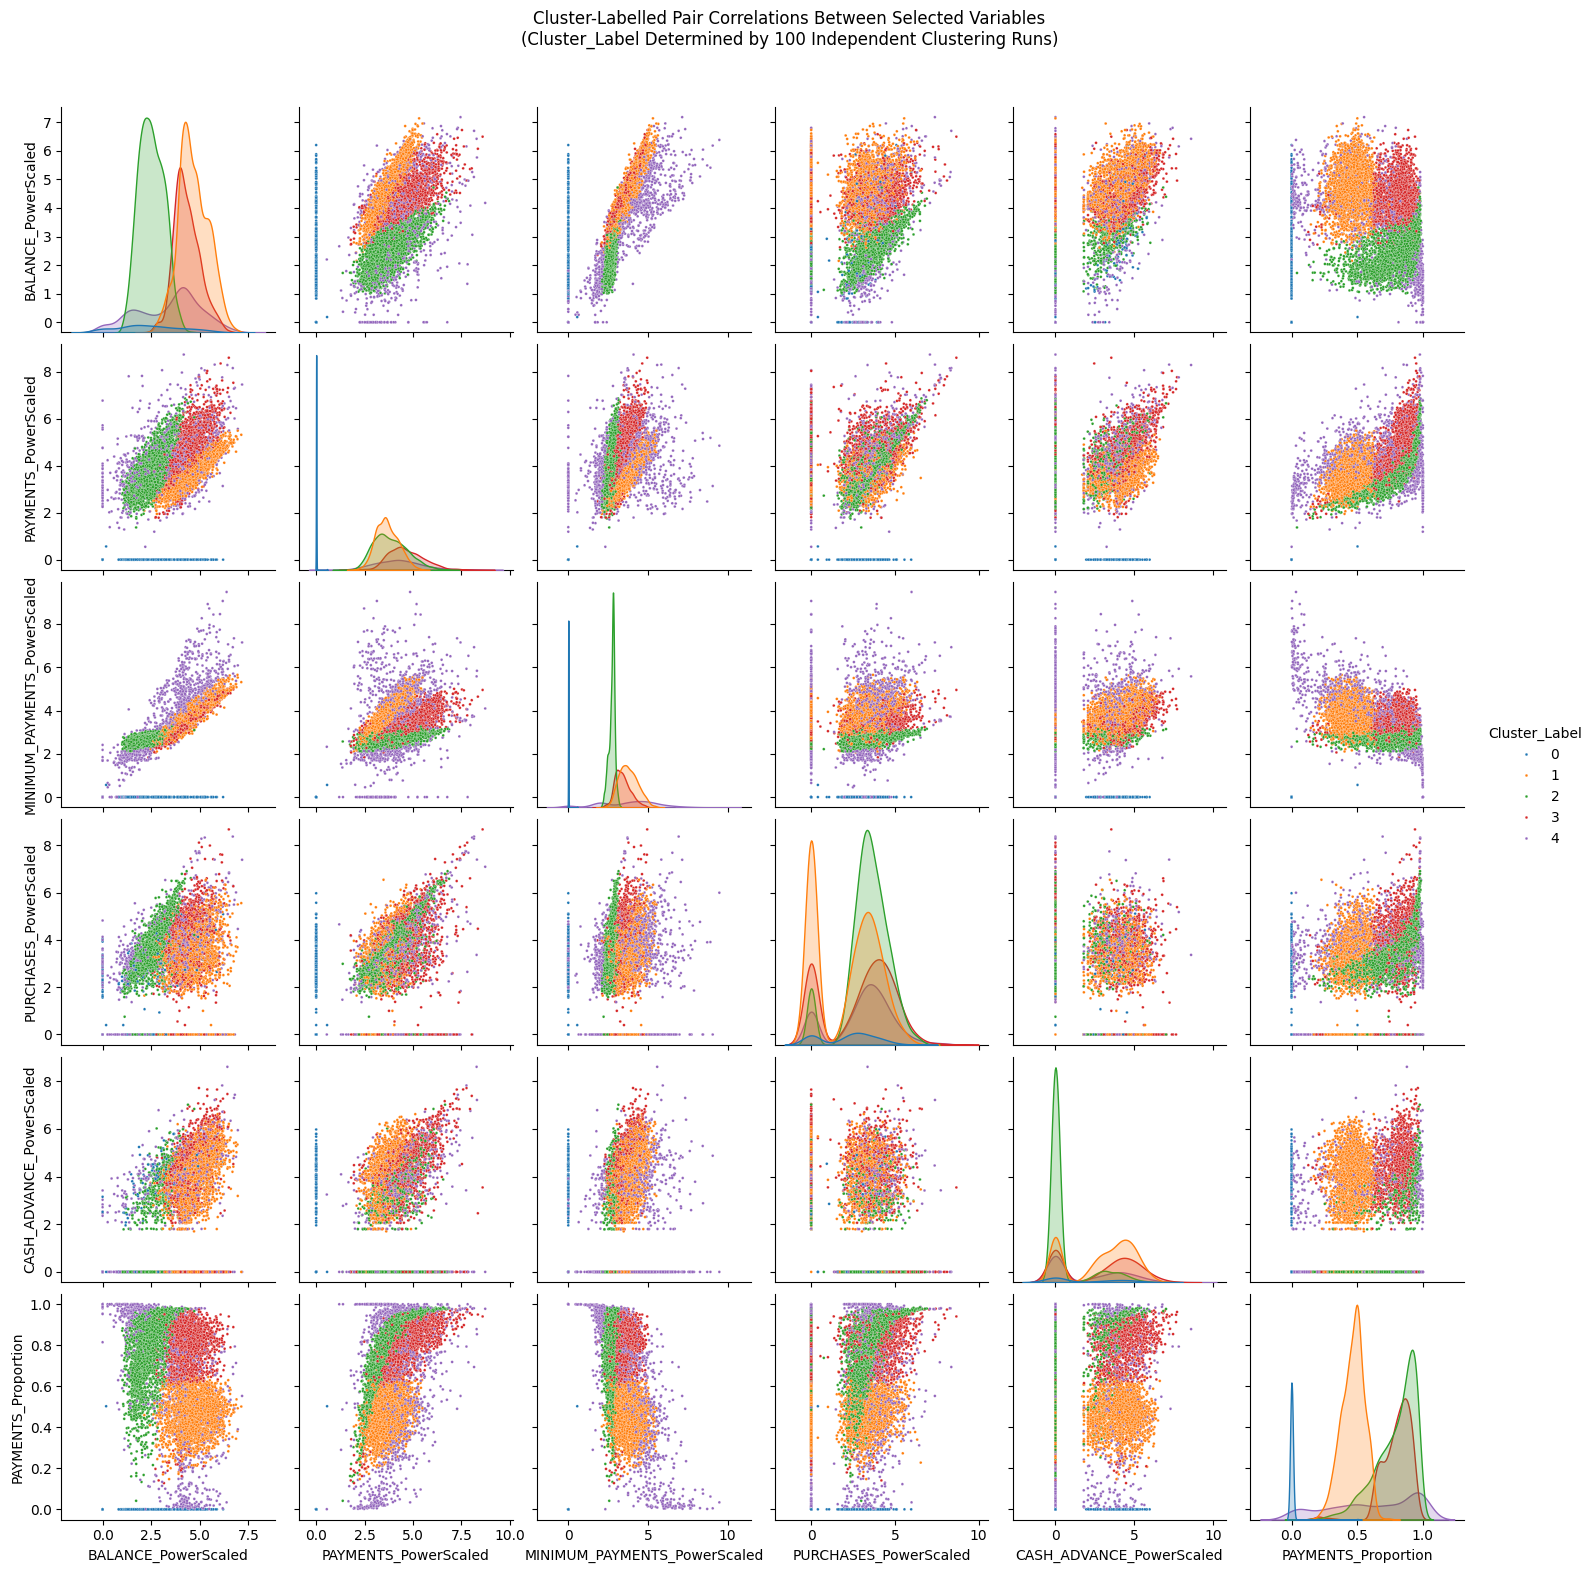

In [28]:
## Pair-plot with color coded by found clusters, to visualize clustering results
g = sns.pairplot(dfp_seg[dfp_seg.columns[:-1]],hue='Cluster_Label',palette='tab10',plot_kws=dict(s=4))
g.fig.suptitle(f'Cluster-Labelled Pair Correlations Between Selected Variables\n(Cluster_Label Determined by {n_runs} Independent Clustering Runs)',y=1.05);

### Meaning of Customer Groups
- Five possible groups of credit card customers:
  - `Cluster_Label` = **2**: **conservative users**
    - low `BALANCE`
    - very limit usage of `CREDIT_LIMIT` ( 0%-20% )
    - very few `CASH_ADVANCE`, `PURCHASES` very often, and prefer with `INSTALLMENTS_PURCHASES`
    - low `MINIMUM_PAYMENTS`, prefer normal `PAYMENTS`
    - nearly flat distribution of `PRC_FULL_PAYMENT`
    - probably willing to borrow less and to complete payments soon as possible
      - a conservative spender, more like a **transactor**
  - `Cluster_Label` = **3**: **moderate users**
    - high `BALANCE` (spending)
    - two sub-groups on `CREDIT_LIMIT` usuage:
      - low (peak at 30%, dominated)
      - high (broad peak at 70%)
    - middle `MINIMUM_PAYMENTS`, prefer normal `PAYMENTS`
    - decay-like distribution of `PRC_FULL_PAYMENT`
    - probably willing to complete payments at moderate pace
      - falling between **transactor** and **revolver** 
  - `Cluster_Label` = **1**: **immoderate users**
    - high `BALANCE` (spending)
    - two sub-groups on `CREDIT_LIMIT` usuage:
      - low (broad peak at 50%)
      - high (peak at 90%, dominated)
    - high `MINIMUM_PAYMENTS`, prefer half `MINIMUM_PAYMENTS` and half normal `PAYMENTS`
    - `PRC_FULL_PAYMENT` almost all at zeros
    - probably no strong will to complete payments on time
      - very likely a **revolver** 
  - `Cluster_Label` = **4**: noise **background users**
    - large variation ranges, cannot be simply categorized to other groups
    - to be further investigated
  - `Cluster_Label` = **0**: probably **new users**
    - almost no records on payments, i.e. lack of user history
    - in other words, probably fresh users, or credit card unused for a while before being active again.
- Main characteristics are listed in following table for comparison of customer groups:

|Customer groups|`Cluster_Label`|Proportion|`BALANCE`|`MINIMUM_PAYMENTS`|Peaks of<br>`PURCHASES_FREQUENCY`|Peaks of<br>`PAYMENTS_Proportion`|Peaks of<br>`BALANCE_CREDIT_Ratio`|`PRC_FULL_PAYMENT`|More notes|
|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|
|conservative users|2|32.7%|low|low|1|0.90|0|nearly flat distrib.|few `CASH_ADVANCE`|
|moderate users|3|20.9%|high|middle|0,1|0.85|0.3, 0.7|decay-like distrib.| |
|immoderate users|1|31.3%|high|high|0,1|0.50|0.5, 0.9|almost all at zeros| |
|background users|4|12.4%|low-high|low-high|0,1|0.0-1.0|0, 1.0|decay-like distrib.| |
|new users|0|2.7%|low-high|0|0,1|0|0, 0.9|almost all at zeros|no payment records|


#### General Picture

In [29]:
## Adding the label results to `dfp`
dfp['Cluster_Label'] = dfp_seg['Cluster_Label']
## Proportion of customer groups
dfp['Cluster_Label'].value_counts(normalize=True).sort_index().reset_index()

,Cluster_Label,proportion
0,0,0.026927
1,1,0.313184
2,2,0.327039
3,3,0.208939
4,4,0.123911


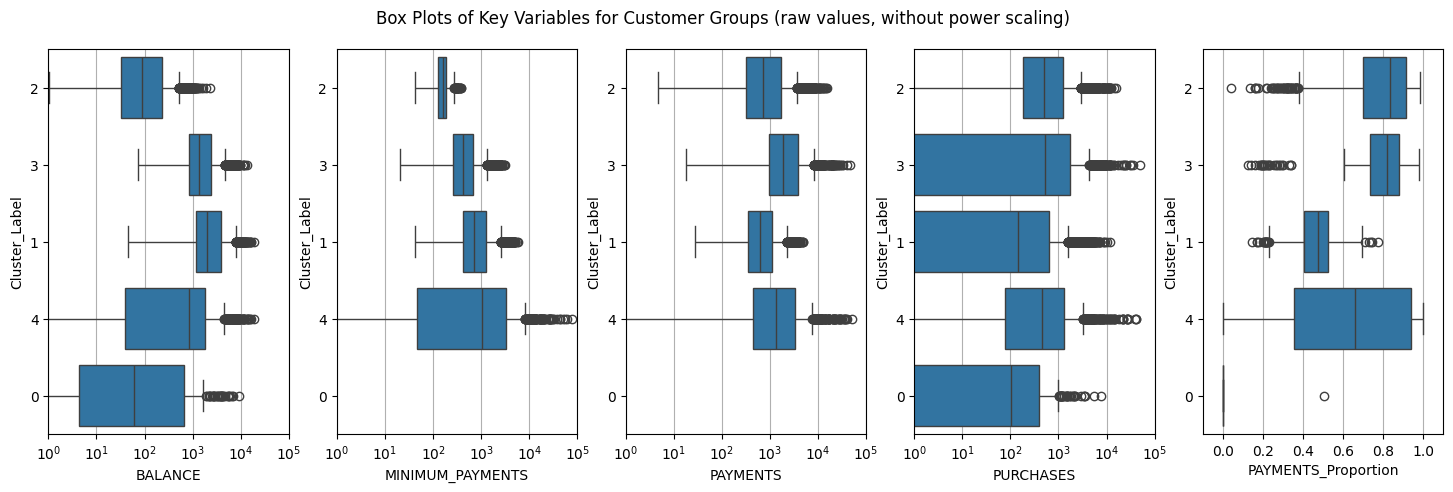

In [30]:
## Box plot of variables without the power scaling
##   Cluster_Label = 2: BALANCE (low), MINIMUM_PAYMENTS (low)
##   Cluster_Label = 3: BALANCE (high), MINIMUM_PAYMENTS (middle)
##   Cluster_Label = 1: BALANCE (high), MINIMUM_PAYMENTS (high)
##   Cluster_Label = 4: BALANCE (broad range), MINIMUM_PAYMENTS (broad range)
##   Cluster_Label = 0: BALANCE (broad range), MINIMUM_PAYMENTS (0)

dt = df[['BALANCE','MINIMUM_PAYMENTS','PAYMENTS','PURCHASES']]
dt['PAYMENTS_Proportion'] = dfp['PAYMENTS_Proportion']
dt['Cluster_Label'] = dfp['Cluster_Label'].map({i:str(i) for i in range(5)})
dt['Cluster_Label_Sort'] = dfp['Cluster_Label'].map({2:0,3:1,1:2,4:3,0:4})
dt.sort_values('Cluster_Label_Sort',inplace=True)
fig, ax = plt.subplots(1,5,figsize=(18,5))
sns.boxplot(data=dt,x='BALANCE',y='Cluster_Label',ax=ax[0])
sns.boxplot(data=dt,x='MINIMUM_PAYMENTS',y='Cluster_Label',ax=ax[1])
sns.boxplot(data=dt,x='PAYMENTS',y='Cluster_Label',ax=ax[2])
sns.boxplot(data=dt,x='PURCHASES',y='Cluster_Label',ax=ax[3])
sns.boxplot(data=dt,x='PAYMENTS_Proportion',y='Cluster_Label',ax=ax[4])
for i in range(4):
    ax[i].set_xlim([1,1e5])
    ax[i].set_xscale('log')
    ax[i].set_xticks([1,1e1,1e2,1e3,1e4,1e5])
    ax[i].xaxis.grid()
ax[4].set_xlim([-0.1,1.1])
ax[4].set_xticks(np.arange(0,1.1,0.2))
ax[4].xaxis.grid()
fig.suptitle('Box Plots of Key Variables for Customer Groups (raw values, without power scaling)',y=0.96);

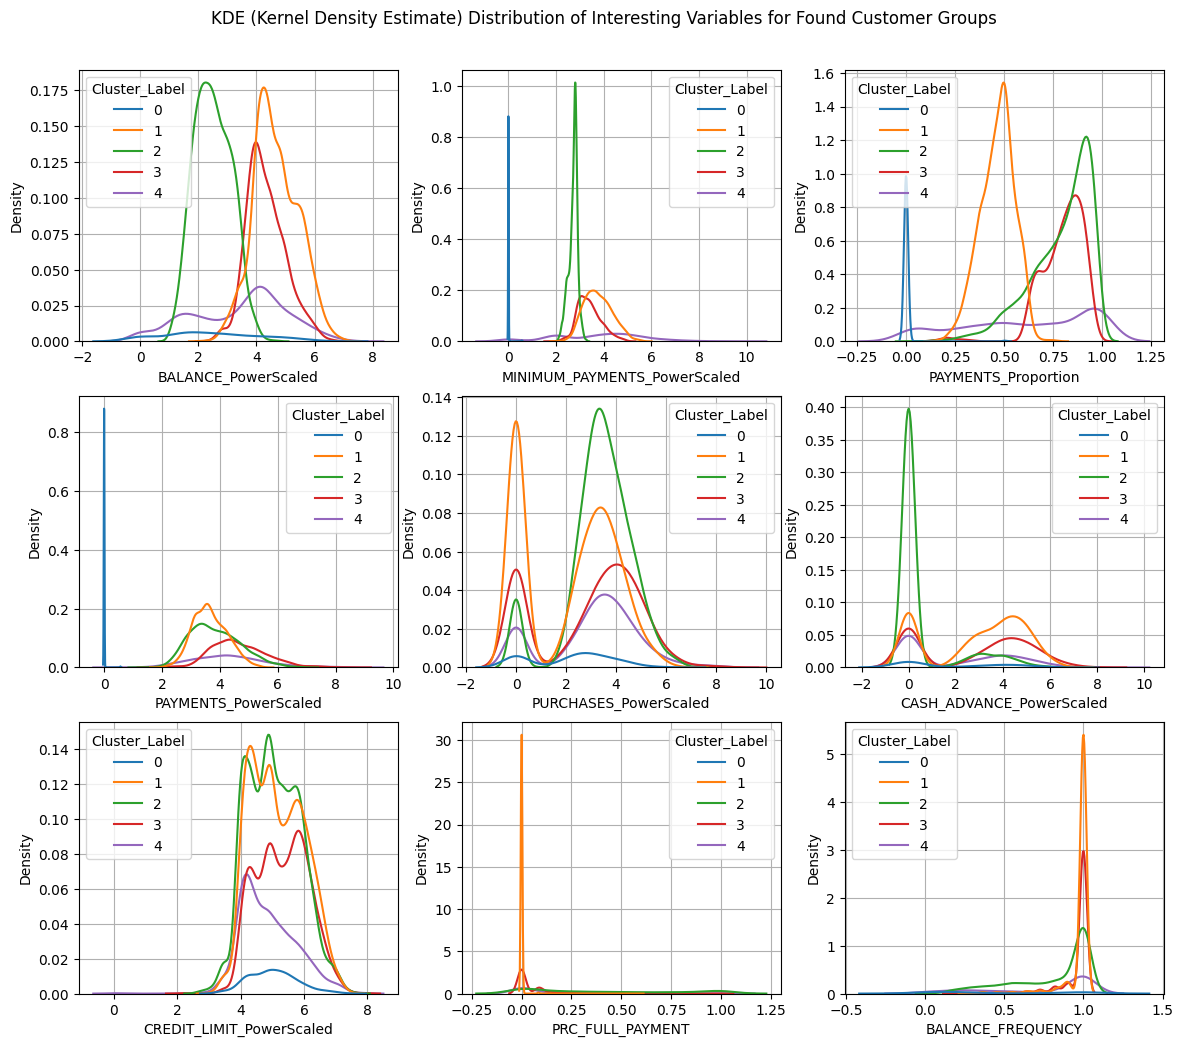

In [31]:
## Variable KDE distributions for customer groups
##   Cluster_Label = 2: BALANCE (low), MINIMUM_PAYMENTS (low), PAYMENTS_Proportion peak (0.90)
##   Cluster_Label = 3: BALANCE (high), MINIMUM_PAYMENTS (middle), PAYMENTS_Proportion peak (0.85)
##   Cluster_Label = 1: BALANCE (high), MINIMUM_PAYMENTS (high), PAYMENTS_Proportion peak (0.50)
##   Cluster_Label = 4: BALANCE (broad range), MINIMUM_PAYMENTS (broad range), PAYMENTS_Proportion peak (broad range)
##   Cluster_Label = 0: BALANCE (broad range), MINIMUM_PAYMENTS (0), PAYMENTS_Proportion peak (0)

fig, ax = plt.subplots(3,3,figsize=(14,12))
sns.kdeplot(data=dfp,x=add_ps('BALANCE'),hue='Cluster_Label',palette='tab10',ax=ax[0,0])
sns.kdeplot(data=dfp,x=add_ps('MINIMUM_PAYMENTS'),hue='Cluster_Label',palette='tab10',ax=ax[0,1])
sns.kdeplot(data=dfp,x='PAYMENTS_Proportion',hue='Cluster_Label',palette='tab10',ax=ax[0,2])
sns.kdeplot(data=dfp,x=add_ps('PAYMENTS'),hue='Cluster_Label',palette='tab10',ax=ax[1,0])
sns.kdeplot(data=dfp,x=add_ps('PURCHASES'),hue='Cluster_Label',palette='tab10',ax=ax[1,1])
sns.kdeplot(data=dfp,x=add_ps('CASH_ADVANCE'),hue='Cluster_Label',palette='tab10',ax=ax[1,2])
sns.kdeplot(data=dfp,x=add_ps('CREDIT_LIMIT'),hue='Cluster_Label',palette='tab10',ax=ax[2,0])
sns.kdeplot(data=dfp,x='PRC_FULL_PAYMENT',hue='Cluster_Label',palette='tab10',ax=ax[2,1])
sns.kdeplot(data=dfp,x='BALANCE_FREQUENCY',hue='Cluster_Label',palette='tab10',ax=ax[2,2])
for i in range(3):
    for j in range(3):
        ax[i,j].grid()
fig.suptitle('KDE (Kernel Density Estimate) Distribution of Interesting Variables for Found Customer Groups',y=0.93);

#### In-depth Details on Customer Borrows

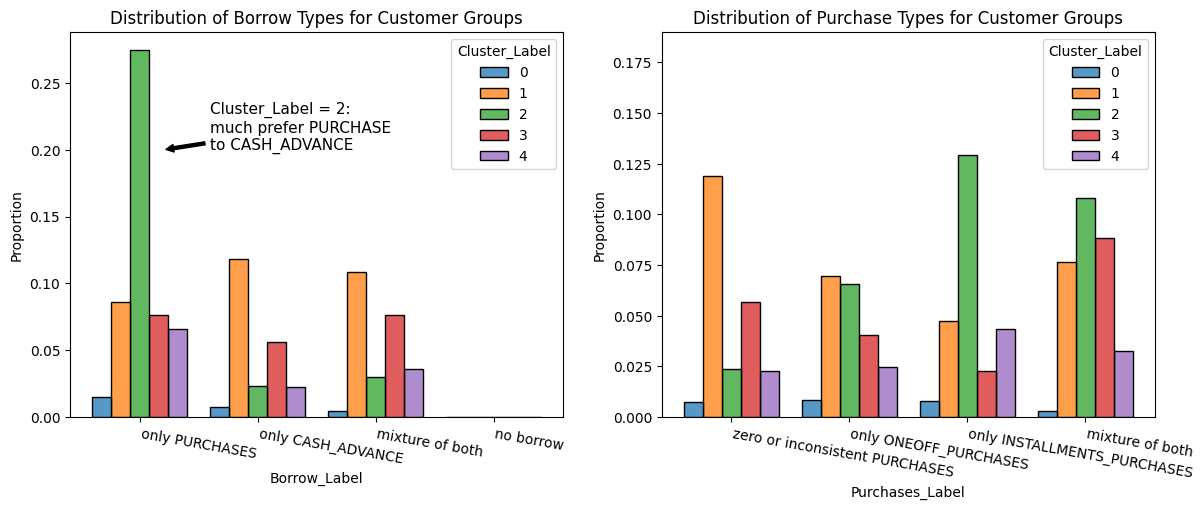

In [32]:
fig, ax = plt.subplots(1,2,figsize=(14,5))

## Distribution of borrow types for customer groups
##   Cluster_Label=2 group: 'only PURCHASES' dominates most
dt1 = dfp[['Borrow_Label','Cluster_Label']]
dt1['Borrow_Label_Sort'] = dt1['Borrow_Label'].map({borrow_label[i]:i for i in range(len(borrow_label))})
dt1.sort_values(['Cluster_Label','Borrow_Label_Sort'],inplace=True)

sns.histplot(data=dt1,x='Borrow_Label',hue='Cluster_Label',stat='proportion',multiple="dodge",shrink=.8,palette='tab10',ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=-10,ha='left')
ax[0].annotate('Cluster_Label = 2: \nmuch prefer PURCHASE \nto CASH_ADVANCE',xy=(0.2,0.2),xytext=(0.6,0.2),
               size=11,arrowprops=dict(arrowstyle='simple',fc='k',ec='k'))
ax[0].set_title('Distribution of Borrow Types for Customer Groups')

## Distribution of purchase types for customer groups
## (see extended discussions in next plots on PURCHASES_FREQUENCY)
dt2 = dfp[['Purchases_Label','Cluster_Label']]
dt2['Purchases_Label_Sort'] = dt2['Purchases_Label'].map({purchases_label[i]:i for i in range(len(purchases_label))})
dt2.sort_values('Purchases_Label_Sort',inplace=True)

sns.histplot(data=dt2,x='Purchases_Label',hue='Cluster_Label',stat='proportion',multiple="dodge",shrink=.8,palette='tab10',ax=ax[1])
ax[1].set_ylim([0,0.19])
ax[1].set_title('Distribution of Purchase Types for Customer Groups')
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=-10,ha='left');

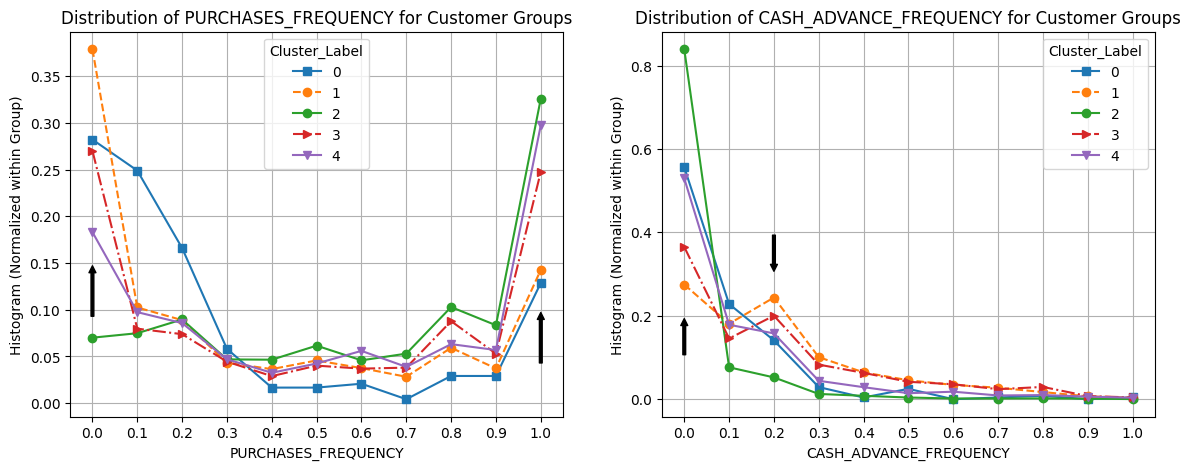

In [33]:
## Distribution of PURCHASES_FREQUENCY
##   Cluster_Label = 0,1,3,4: peaks at 0 and 1
##   Cluster_Label = 2: peak only at 1

## Distribution of CASH_ADVANCE_FREQUENCY
##   In general, all at low frequency regime
##   Cluster_Label = 0,1,3,4: main peak at 0, and side peak at 0.2
##   Cluster_Label = 2: dominated by zero

fig, ax = plt.subplots(1,2,figsize=(14,5))

cols = ['PURCHASES_FREQUENCY','CASH_ADVANCE_FREQUENCY']
marker = ['s','o','o','>','v']
linestyle = ['-','--','-','-.','-']
for i in range(5):
    for j in range(2):
        cnts, bins = np.histogram(dfp[dfp['Cluster_Label']==i][cols[j]],bins=11,range=[-0.05,1.05])
        cnts = cnts/np.sum(cnts)
        ax[j].plot(np.arange(0,1.1,0.1),cnts,c=tab10[i],marker=marker[i],linestyle=linestyle[i])
        ax[j].set_xticks(np.arange(0,1.1,0.1))
        ax[j].legend([str(i) for i in range(5)],title='Cluster_Label')
        ax[j].grid()
        ax[j].set_xlabel(cols[j])
        ax[j].set_ylabel('Histogram (Normalized within Group)')
        ax[j].set_title(f'Distribution of {cols[j]} for Customer Groups')
ax[0].annotate('',xy=(0,0.15),xytext=(0,0.09),arrowprops=dict(arrowstyle='simple',fc='k'))
ax[0].annotate('',xy=(1,0.1),xytext=(1,0.04),arrowprops=dict(arrowstyle='simple',fc='k'))
ax[1].annotate('',xy=(0,0.2),xytext=(0,0.1),arrowprops=dict(arrowstyle='simple',fc='k'))
ax[1].annotate('',xy=(0.2,0.3),xytext=(0.2,0.4),arrowprops=dict(arrowstyle='simple',fc='k'));

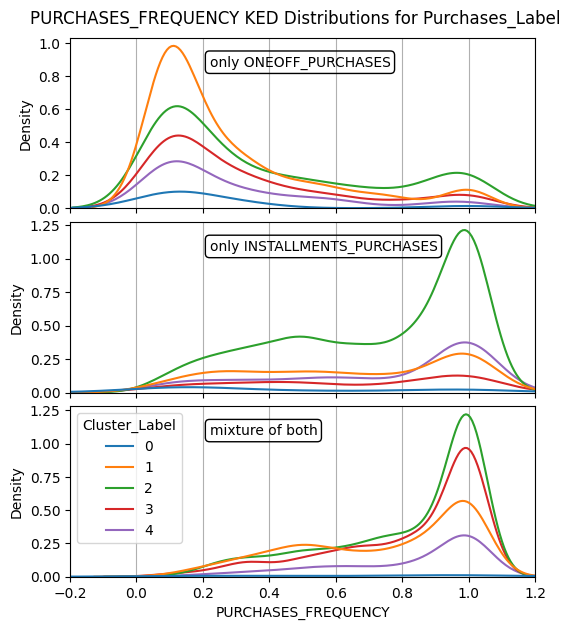

In [34]:
## Further Purchase_Label details on PURCHASES_FREQUENCY
##   (for easy comparison, ONEOFF_PURCHASES_FREQUENCY and PURCHASES_INSTALLMENTS_FREQUENCY are not included)
##   Only ONEOFF_PURCHASES: very low PURCHASES_FREQUENCY
##   PURCHASES with Installments: very high PURCHAASE_FREQUENCY
##   Cluster_Label = 2: prefer PURCHASES with Installments (only or mixture with Installments)

fig, ax = plt.subplots(3,1,figsize=(6,7))
plt.subplots_adjust(hspace=0.08)
for i in range(2):
    sns.kdeplot(dfp[dfp['Purchases_Label']==purchases_label[i+1]],x='PURCHASES_FREQUENCY',hue='Cluster_Label',palette='tab10',legend=False,ax=ax[i])
    ax[i].set_xticklabels([])
    ax[i].set_xlabel('')
    ax[i].set_xlim([-0.2,1.2])
    ax[i].xaxis.grid()
    t = ax[i].get_ylim()
    ax[i].text(0.22,(t[0]+5*t[1])/6,purchases_label[i+1],bbox=dict(facecolor='none', boxstyle='round'))
sns.kdeplot(dfp[dfp['Purchases_Label']==purchases_label[3]],x='PURCHASES_FREQUENCY',hue='Cluster_Label',palette='tab10',ax=ax[2])
ax[2].set_xlim([-0.2,1.2])
ax[2].xaxis.grid();
t = ax[2].get_ylim()
ax[2].text(0.22,(t[0]+5*t[1])/6,purchases_label[3],bbox=dict(facecolor='none', boxstyle='round'))
fig.suptitle('PURCHASES_FREQUENCY KED Distributions for Purchases_Label',y=0.92);

#### In-depth Details on Customer Status

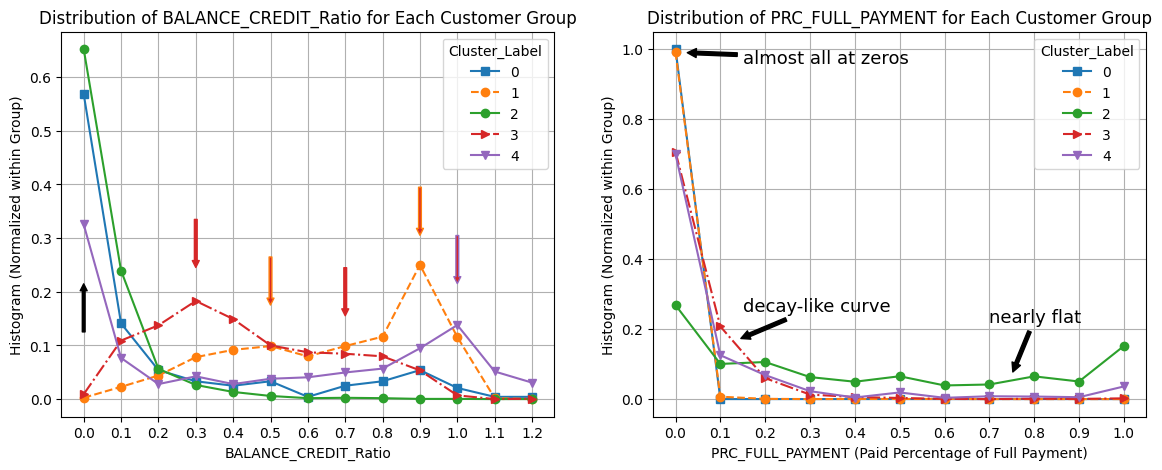

In [35]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
marker = ['s','o','o','>','v']
linestyle = ['-','--','-','-.','-']

## Comparison of `BALANCE_CREDIT_Ratio` Distributions for customer groups
##   Cluster_Label = 0,4: peaks at 0 and 0.9/1.0
##   Cluster_Label = 1: peaks at 0.5 and 0.9 (dominated)
##   Cluster_Label = 2: modest usage of credit
##   Cluster_Label = 3: peaks at 0.3 (dominated) and 0.7
for i in range(5):
    cnts, bins = np.histogram(dfp[dfp['Cluster_Label']==i]['BALANCE_CREDIT_Ratio'],bins=13,range=[-0.05,1.25])
    cnts = cnts/np.sum(cnts)
    ax[0].plot(np.arange(0,1.3,0.1),cnts,c=tab10[i],marker=marker[i],linestyle=linestyle[i])
ax[0].set_xticks(np.arange(0,1.3,0.1))
ax[0].legend([str(i) for i in range(5)],title='Cluster_Label')
ax[0].grid()
ax[0].set_xlabel('BALANCE_CREDIT_Ratio')
ax[0].set_ylabel('Histogram (Normalized within Group)')
ax[0].annotate('',xy=(0,0.22),xytext=(0,0.12),arrowprops=dict(arrowstyle='simple',fc='black'))
ax[0].annotate('',xy=(0.3,0.24),xytext=(0.3,0.34),arrowprops=dict(arrowstyle='simple',fc=tab10[3],ec=tab10[3]))
ax[0].annotate('',xy=(0.7,0.15),xytext=(0.7,0.25),arrowprops=dict(arrowstyle='simple',fc=tab10[3],ec=tab10[3]))
ax[0].annotate('',xy=(0.5,0.17),xytext=(0.5,0.27),arrowprops=dict(arrowstyle='simple',fc=tab10[3],ec=tab10[1]))
ax[0].annotate('',xy=(0.9,0.3),xytext=(0.9,0.4),arrowprops=dict(arrowstyle='simple',fc=tab10[3],ec=tab10[1]))
ax[0].annotate('',xy=(1,0.21),xytext=(1,0.31),arrowprops=dict(arrowstyle='simple',fc=tab10[3],ec=tab10[4]))
ax[0].set_title('Distribution of BALANCE_CREDIT_Ratio for Each Customer Group')

## Comparison of `PRC_FULL_PAYMENT` Distributions for customer groups
##   Cluster_Label=0,1: almost at zeros, probably means these customers do not start to pay yet
##   Cluster_Label=2: more or less flat, probably means these customers incline to pay quick
##   Cluster_Label=3,4: decay-like, probably means these customers have willing to pay  
for i in range(5):
    cnts, bins = np.histogram(dfp[dfp['Cluster_Label']==i]['PRC_FULL_PAYMENT'],bins=11,range=[-0.05,1.05])
    cnts = cnts/np.sum(cnts)
    ax[1].plot(np.arange(0,1.1,0.1),cnts,c=tab10[i],marker=marker[i],linestyle=linestyle[i])
ax[1].set_xticks(np.arange(0,1.1,0.1))
ax[1].legend([str(i) for i in range(5)],title='Cluster_Label')
ax[1].grid()
ax[1].set_xlabel('PRC_FULL_PAYMENT (Paid Percentage of Full Payment)')
ax[1].set_ylabel('Histogram (Normalized within Group)')
ax[1].annotate('almost all at zeros',xy=(0.02,0.99),xytext=(0.15,0.96),size=13,arrowprops=dict(arrowstyle='simple',fc='k'))
ax[1].annotate('decay-like curve',xy=(0.14,0.17),xytext=(0.15,0.25),size=13,arrowprops=dict(arrowstyle='simple',fc='k'))
ax[1].annotate('nearly flat',xy=(0.75,0.07),xytext=(0.7,0.22),size=13,arrowprops=dict(arrowstyle='simple',fc='k'))
ax[1].set_title('Distribution of PRC_FULL_PAYMENT for Each Customer Group');

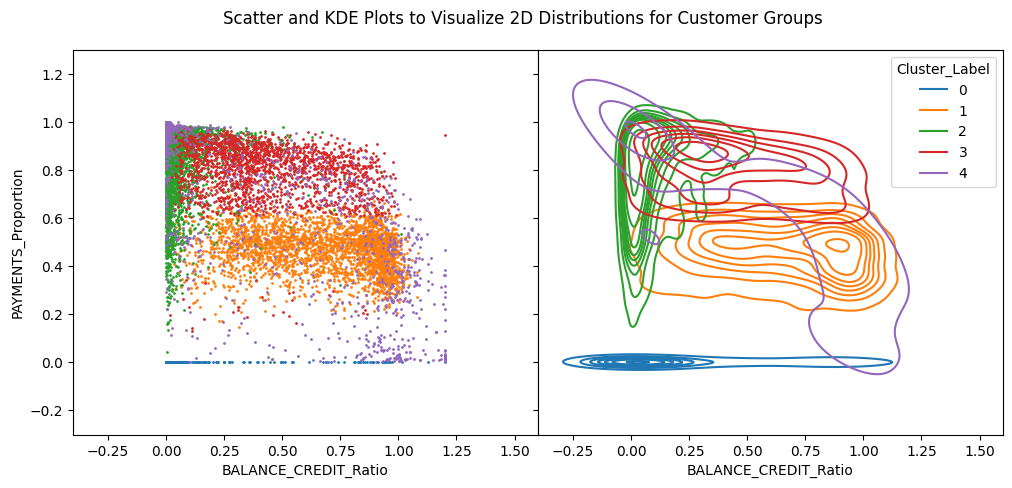

In [36]:
## A view of 2D distributions for customer groups
##   (for a better view on BALANCE_CREDIT_Ratio distributions)
fig, ax = plt.subplots(1,2,figsize=(12,5))
plt.subplots_adjust(wspace=0.0)
for i in range(5):
    dt = dfp[dfp['Cluster_Label']==i]
    ax[0].scatter(dt['BALANCE_CREDIT_Ratio'],dt['PAYMENTS_Proportion'],s=1,c=tab10[i])
ax[0].set_xlabel('BALANCE_CREDIT_Ratio')
ax[0].set_ylabel('PAYMENTS_Proportion')
sns.kdeplot(dfp,x='BALANCE_CREDIT_Ratio',y='PAYMENTS_Proportion',hue='Cluster_Label',palette='tab10',ax=ax[1])
ax[0].set_xlim(ax[1].get_xlim())
ax[0].set_ylim(ax[1].get_ylim())
ax[1].set_ylabel('')
ax[1].set_yticklabels([])
fig.suptitle('Scatter and KDE Plots to Visualize 2D Distributions for Customer Groups',y=0.96);

### Suggestions for Marketing Strategy

- `Cluster_Label` = **2**, **conservative users**
  - encourage them to spend more
  - encourage them to use the option of Minimum Payments
  - encourage them to use Cash Advace service
- `Cluster_Label` = **3**: **moderate users**
  - high-value users
  - attract them by loyality programs, e.g. regular benefits or rewards
  - encourage them to invite new users
- `Cluster_Label` = **1**: **immoderate users**
  - some are risky users (requiring additional study)
- `Cluster_Label` = **0**: **new users**
  - encourage them to keep using credit card, so more usuage records will be beneficial

#### Limits of The Current Study
- Only natural clusters are identified. In reality, **actual marketing goals** should be taken into account.
  - e.g. installment-focused marketing will need more corresponding consideration in customer segmentation
- The group of **background users** is not well investigated, and additional study will be required to understand them. 
- **Customer infomation** in the raw data is somehow **limited**:
  - `BALANCE` is single-month data, while `PAYMENTS` and `MINIMUM_PAYMENTS` are intrinsically integration of multiple months' results
    - fluctuation of `BALANCE` from month to month, may deteriorate reliability of customer labels in this study
    - average and standard deviation value of `BALANCE` over months may help to improve the situation
  - `FREQUENCY` and `TRX` related variables are defined inconsistently, and therefore not fully usuable
  - additional information, such as customer's card-holding time, and other profiles would be helpful in the segmentation
  - longer period of the data will definitely help to reveal a more reliable picture of customer groups